In [1]:
#Student Name:    Philippe C. Rivet
#Student Number:  10105954
#Student Email:   13cpr@queensu.ca
#Description:     Submission for CISC 372 A1 with comments added for descriptive purposes

# download data (-q is the quiet mode)
! wget -q https://github.com/CISC-372/Notebook/releases/download/a1/test.csv -O test.csv
! wget -q https://github.com/CISC-372/Notebook/releases/download/a1/train.csv -O train.csv



'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


traning 7631
testing 7632


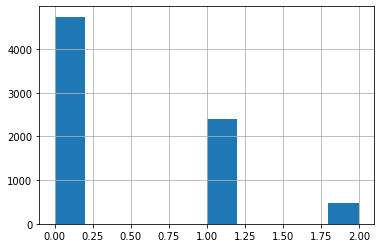

In [2]:
import pandas as pd #import library for use of predefined functions

Xy_train = pd.read_csv('train.csv', engine='python') #read in training set datums
X_train = Xy_train.drop(columns=['price_rating'])    #remove specific column
y_train = Xy_train[['price_rating']]                 #target for prediction (trinary classification)

print('traning', len(X_train))                       #DEBUG
Xy_train.price_rating.hist()                         #display histogram visualization

X_test = pd.read_csv('test.csv', engine='python')    #read in test set datums
testing_ids = X_test.Id                              #isolate identifier col
print('testing', len(X_test))                        #DEBUG


In [6]:
# model training and tuning
import numpy as np  #useful importation as before
import sklearn
import xgboost
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0) #set seed for pseudo-random algos for consistency across runs

numeric_features = ['bedrooms', 'review_scores_location', 'accommodates', 'beds'] #isolate da numbers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]) #fill in missing values with the median and scale as appropriate per feature

categorical_features = [
  'property_type', 'is_business_travel_ready', 'room_type', ]  #isolate da categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  #instead of scaling we ignore unknowns and replace missing vals with a standard string

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])  #specify data objects to be transformed for the regression

#regr = Pipeline(steps=[('preprocessor', preprocessor),
                        #('regressor', XGBClassifier(
                          #objective='multi:softmax', seed=1))])   #set up pipeline for DS process
                                                                   #in this case XGBoost is used, an ensemble method which deploys 
                                                                   #a combination of linear classifiers (decision trees) for improved performance & parallelization

#regr = Pipeline(steps=[('preprocessor', preprocessor),
                      #('regressor', BaggingClassifier(
                          #))])

#regr = Pipeline(steps=[('preprocessor', preprocessor),
                      #('regressor', RadiusNeighborsClassifier(
                          #))])

#regr = Pipeline(steps=[('preprocessor', preprocessor),
                      #('regressor', AdaBoostClassifier(
                          #))])

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', AdaBoostClassifier(
                          ))])

X_train = X_train[[*numeric_features, *categorical_features]]     #JA
X_test = X_test[[*numeric_features, *categorical_features]]       #OKEI

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)

'''
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth':[20, 40]
}
'''

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [200, 400],
    #'regressor__learning_rate:':[2,4]
    #'regressor__max_depth':[20, 40]
}

grid_search = GridSearchCV(
    regr, param_grid, cv=10, verbose=3, n_jobs=4, 
    scoring='accuracy')   #search for best parameters w/ built-in cross validation method
                          #Changing to RandomizedSearch resulted in faster execution but similar lower performance

grid_search.fit(X_train, np.ravel(y_train))   #test fit, necessary to input as flattened numeric list

#DESCRIPTION OF MODIFICATIONS

#Classifier 1:      Radius Neighbors
#Reasoning:         Establishment of high-dim geometric space for radius measurement
#Expected outcome:  Lower performance due to curse of dimensionality
#Actual outcome:    Best score NaN (Not A Number) due to presence of categorical features

#Classifier 2:      Bagging
#Reasoning:         Alternative ensemble classifier test (samples drawn with replacement)
#Expected outcome:  Higher performance due to leveraging of randomness
#Actual outcome:    Lower performance resulting from compositional error, underfitting

#Classifier 3:      AdaBoost
#Reasoning:         Another alternative ensemble classifier test (iterated copying with weight adjustment for wrong classes)
#Expected outcome:  Higher performance due to isolation of difficulties
#Actual outcome:    Slight overfitting due to strength of corrections

print('best score {}'.format(grid_search.best_score_))    #DISPLAY RESULT

Fitting 10 folds for each of 2 candidates, totalling 20 fits
best score 0.7021354120206131


In [10]:
# Prediction & generating the submission file
y_pred = grid_search.predict(X_test)
result=pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred})
print(result)
result.to_csv(index=False)

         Id  price_rating
0     12748             0
1     16822             0
2      3325             0
3      9234             0
4      9708             1
...     ...           ...
7627   2797             1
7628  10363             0
7629   4932             0
7630   4565             0
7631    994             0

[7632 rows x 2 columns]


'Id,price_rating\r\n12748,0\r\n16822,0\r\n3325,0\r\n9234,0\r\n9708,1\r\n18184,1\r\n732,0\r\n4311,0\r\n7583,1\r\n16682,1\r\n2496,0\r\n9271,1\r\n5274,0\r\n1291,0\r\n3056,0\r\n8588,0\r\n15971,0\r\n15870,0\r\n1962,2\r\n11920,1\r\n3037,0\r\n18591,1\r\n7872,1\r\n5110,0\r\n16990,0\r\n12383,0\r\n1199,1\r\n3986,0\r\n17998,1\r\n9501,0\r\n4465,0\r\n17925,0\r\n8493,0\r\n13417,0\r\n5662,1\r\n12869,0\r\n4908,0\r\n11393,1\r\n8655,0\r\n747,1\r\n11115,1\r\n11473,0\r\n13326,0\r\n4957,1\r\n15203,1\r\n11776,1\r\n10558,0\r\n4468,0\r\n5349,0\r\n5700,0\r\n4456,0\r\n11855,1\r\n14281,0\r\n19504,1\r\n3804,0\r\n10644,0\r\n2895,0\r\n5578,0\r\n12868,1\r\n12322,0\r\n10095,0\r\n15880,0\r\n6099,1\r\n11949,0\r\n15865,0\r\n6688,0\r\n9659,0\r\n586,1\r\n7755,0\r\n17172,0\r\n10866,1\r\n9461,1\r\n14230,0\r\n2633,0\r\n8170,0\r\n17284,0\r\n15182,0\r\n1235,0\r\n7681,0\r\n1265,1\r\n182,1\r\n11210,1\r\n11033,0\r\n13152,1\r\n11077,0\r\n19028,0\r\n3718,0\r\n619,0\r\n12323,0\r\n11732,0\r\n10402,0\r\n17422,0\r\n15470,1\r\n10685,1\r

#ANSWERS TO QUESTIONS

1. The number of trials per day on the public leaderboard is limited to ensure that a user does NOT game the system by submitting over and over with slightly different parameter settings.

2. In the case of the private leaderboard, its usage is limited to post-submission deadline for evaluation to see how each user model generalizes through a different test set than for the public case.

3. The final model used was AdaBoost and its flexibility was controlled by changing the learning rate and random state parameters. The former trades off against the number of estimators by changing the classifier weight per iteration (higher -> bigger contribution). The latter once again deploys randomness at each classification stage for hypothetically higher performance.